In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

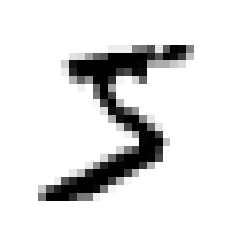

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

Both the features and the label for observation zero match, the image is a five.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

MNIST data are already randomly split between training and test data. The first 60,000 are training and the last 10,000 are test.

**Create a 5 signature detector using a classifier**

In [8]:
y_train_5 = (y_train == '5') # True for all 5's and false for all other digits
y_test_5 = (y_test == '5')
y_train_5.shape

(60000,)

In [9]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [10]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

**Cross-Validation Accuracy**

In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

96% accuracy on all cross-validation folds for the number 5 signature. Let's see accuracy on non-5.

In [14]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy on not 5 signatures. Likely to improve when we define all signatures.

**Confusion Matrix**

In [16]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

53.8k correctly predicted non 5 (true negatives) and 3.5K correctly predicted 5 (true positives).
687 non 5 incorrectly classified as 5 (false positives) and 1.8K incorrectly classified as non 5 (false negatives).

**Precision and Recall**

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred) # 3530/(3530+687)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred) # 3530/(3530+1891)

0.6511713705958311

This particular classifier is not yet suitable for production, but it's a start.

In [20]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Precision and Recall Tradeoffs**

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.grid()
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=12)
    plt.axis([-50000, 50000, 0, 1]) 


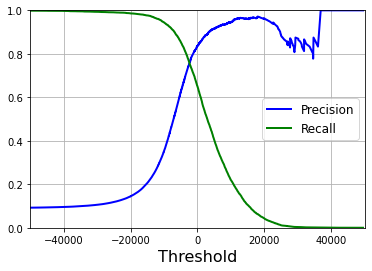

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

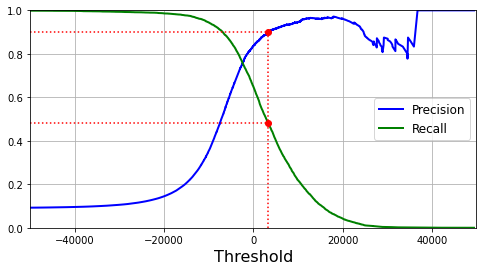

In [25]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                          
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)

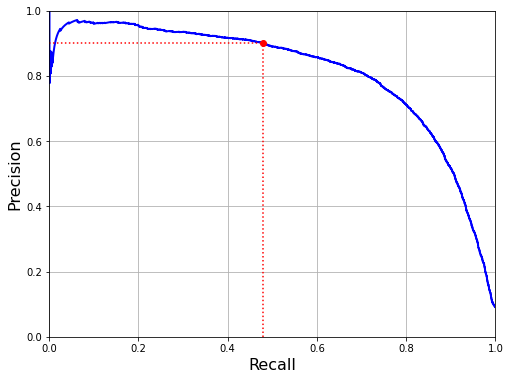

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([rs, rs], [0., ps], "r:")
plt.plot([0.0, rs], [ps, ps], "r:")
plt.plot([rs], [ps], "ro")
plt.show()

**ROC Curve**

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

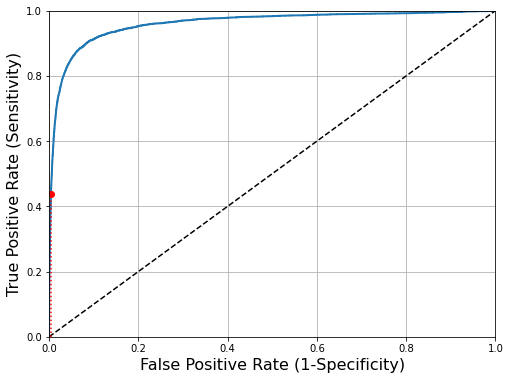

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize=16) 
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                      
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")                                              
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Compare with a Random Forest Classifier**

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

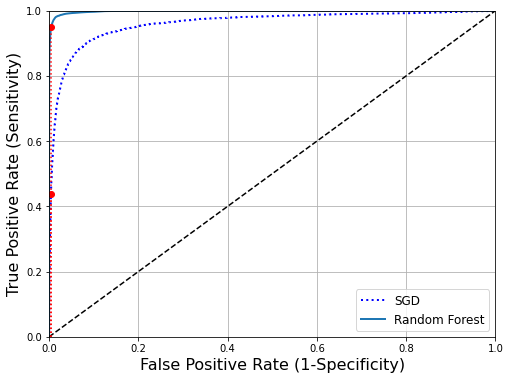

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145